
# 문제정의
이 대회는 많은 사람을 죽음으로 몰고 간 `Titanic 호 침몰 사건`을 주제로 다룬다.


생존에 영향을 미친 여러 요인이 있겠지만, 대회에서 주어진 Train 승객들의 정보만으로 Test 승객들의 생존 여부를 예측해보려고 한다.


생존과 연루되어 있다고 생각되는 몇 가지의 요소들에 대해 분석하여 어떤 조건을 갖춘 그룹들이 생존할 확률이 더 높았는지에 대해 알아보려고 한다.




# 데이터 수집

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
import matplotlib as mpl
from collections import defaultdict
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.family'] = 'KBIZmjo M'
%matplotlib inline

In [139]:
train = pd.read_csv('Desktop/데이터분석/titanic/train.csv')
test = pd.read_csv('Desktop/데이터분석/titanic/test.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [118]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

----------------------------------------------------
총 891명의 탑승자가 있다.(학습대상) 



하지만 Age, Cabin, Embarked는 몇몇 탑승자들의 정보가 누락되어있다.

- Age : 177명 누락(약 20%)
- Cabin : 687명 누락(약 77%)
- Embarked : 2명 누락(약 0.2%)


In [119]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [120]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

---------------------------------------------
test탑승자의 정보도 일부 누락되어있다. --> Age, Fare, Cabin  

# 데이터 마이닝
가공하지 않은 원형의 데이터를 새로운 유형으로 가공하는 것이다. -> 정보를 목적에 맞고 편리하게 구성 및 사용하기 위해

In [187]:
#나이 분류 함수
def AgeClassify(k):
    if 0<=k<=9: 
        return 0
    elif k<20:#10대
        return 10
    elif k<30:#20대
        return 20
    elif k<40:#30대
        return 30
    elif k<50:#40대
        return 40
    elif k<60:#50대
        return 50
    elif k<70:#60대
        return 60
    elif k<80:#70대
        return 70
    else:#80이상
        return 80

## Null값이 하나라도 있는 승객은 혼자 왔을 확률이 높고, 생존 확률이 낮은 승객일까?

In [231]:
#null값이 하나라도 있으면 passengerid 저장
nullP = list(train.loc[train.Age.isnull()|train.Cabin.isnull()|train.Embarked.isnull()].PassengerId)
len(nullP)

708

In [172]:
#사망자와 생존자 카운트(null값이 하나라도 있는 승객 대상)
train.loc[train.Age.isnull()|train.Cabin.isnull()|train.Embarked.isnull()].Survived.value_counts()

0    489
1    219
Name: Survived, dtype: int64

In [174]:
#null값이 있는 승객 중 혼자 온 승객 카운트
Alone = 0
for n in nullP:
    num = 0
    num += train.loc[train.PassengerId == n].SibSp + train.loc[train.PassengerId == n].Parch
    if int(num) == 0:
        Alone += 1
print("혼자온 승객 : {}". format(Alone))

혼자온 승객 : 458


In [192]:
#사망자이고 혼자인 승객
DAnum = int(train.loc[train.Survived == 0].loc[train.SibSp == 0].loc[train.Parch == 0].Survived.value_counts())
cnum = 0 
for i in list(train.loc[train.Survived == 0].loc[train.SibSp == 0].loc[train.Parch == 0].PassengerId):
    if i in nullP:
        cnum += 1
print("전체 승객 중 사망자이고 혼자 온 승객 수: {}".format(DAnum))
print("위 승객 중 null값이 하나라도 있는 승객 수: {}".format(cnum))

전체 승객 중 사망자이고 혼자 온 승객 수: 374
위 승객 중 null값이 하나라도 있는 승객 수: 343


In [193]:
#전체 승객의 생존여부
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

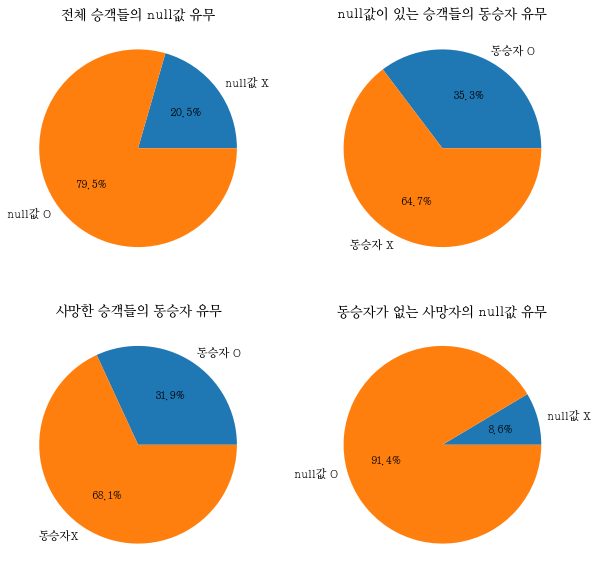

In [216]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.title("전체 승객들의 null값 유무")
plt.pie([891-708, 708], labels = ['null값 X', 'null값 O'],autopct ='%1.1f%%')
plt.subplot(2,2,2)
plt.title("null값이 있는 승객들의 동승자 유무")
plt.pie([708-458, 458], labels= ['동승자 O', '동승자 X'],autopct ='%1.1f%%')
plt.subplot(2,2,3)
plt.title("사망한 승객들의 동승자 유무")
plt.pie([549-374, 374], labels=['동승자 O', '동승자X'],autopct ='%1.1f%%')
plt.subplot(2,2,4)
plt.title("동승자가 없는 사망자의 null값 유무")
plt.pie([374-342, 342], labels=['null값 X', 'null값 O'],autopct ='%1.1f%%')
plt.show()

----------------------------------------
<strong>전체 891명</strong>의 승객 중 <strong>708명(약 80%)이 null값</strong>을 하나라도 가지고 있고, 

이들 중 <strong>동승자가 없는 승객은 458</strong>명이다. (약 65%)

그리고 전체 승객 중 <strong>사망자이면서 혼자 온 승객은 374명</strong>으로, <strong>사망한 승객 549명의 68%</strong>이다.

또한, <strong>위 374명 중 342명이 null값</strong>을 하나라도 가지고 있다.<strong> (약 91%)</strong>


In [249]:
#동승자가 없는 승객의 null값 유무
#동승자 없는 승객
Altmp = list(train.loc[train.SibSp == 0].loc[train.Parch == 0].PassengerId)
#동승자가 없는 승객 중 null값이 없는 승객 수
restmp = 0
for i in Altmp:
    if i in nullP:
        restmp += 1
print("둘 다 해당 : {}".format(restmp))
print("전체: {}".format(len(Altmp)))

둘 다 해당 : 458
전체: 537


In [248]:
#null값이 있고 , 동승자가 없는 승객의 사망여부
restmp2 = defaultdict(int)
for i in nullP:
    if i in Altmp:
        restmp2[int(train.loc[train.PassengerId == int(i)].Survived)]+= 1
restmp2


defaultdict(int, {1: 115, 0: 343})

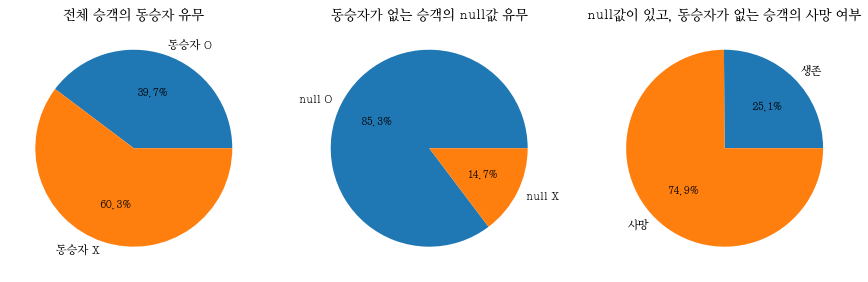

In [257]:
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
plt.title("전체 승객의 동승자 유무")
plt.pie([891-537, 537], labels=["동승자 O","동승자 X"],autopct ='%1.1f%%')
plt.subplot(1,3,2)
plt.title("동승자가 없는 승객의 null값 유무")
plt.pie([458, 537-458], labels=["null O","null X"],autopct ='%1.1f%%')
plt.subplot(1,3,3)
plt.title("null값이 있고, 동승자가 없는 승객의 사망 여부")
plt.pie([115,343], labels=["생존", "사망"], autopct ='%1.1f%%')
plt.show()

-------------------
전체 승객의 약 60%가 동승자가 없고, 

동승자가 없는 승객 중 약 85%가 null값이 있다.

null값이 있고, 동승자가 없는 승객 중 약 75%가 사망했다.

---------------------------
### 결론
동승자가 없고, 

## 알파벳별로 Cabin(객실번호)을 분류하여 분석하기

In [6]:
train.Cabin.value_counts().head(10)

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
E101           3
C22 C26        3
D              3
F2             3
E67            2
B5             2
Name: Cabin, dtype: int64

In [7]:
#각 객실을 알파벳으로 분류하고 생존율 계산 
#각 객실에 묵은 사람들의 수, 생존자 수
num = defaultdict(int)
surv = defaultdict(int)
for i,j in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].Survived) :
    num[i[0]] += 1
    surv[i[0]] += j
    
total = defaultdict(int)
for i in surv.keys():
    total[i] = surv[i]/num[i]

print('{}: {}'.format('각 객실별 승객 수',list(sorted(num.items()))))
total= pd.DataFrame(list(sorted(total.items())), index = list(sorted(total)))
total

각 객실별 승객 수: [('A', 15), ('B', 47), ('C', 59), ('D', 33), ('E', 32), ('F', 13), ('G', 4), ('T', 1)]


,0,1
A,A,0.466667
B,B,0.744681
C,C,0.593220
D,D,0.757576
E,E,0.750000
F,F,0.615385
G,G,0.500000
T,T,0.000000


----------------------------------------------
각 객실별(알파벳으로 분류) 생존확률을 나타내보았다. 

B,D,E로 시작하는 객실들의 생존확률은 70%가 넘는다. 이 객실에 묵은 승객들의 정보가 궁금하다.


### B,D,E에 묵은 승객들은 어떤 승객들인가?

<BarContainer object of 9 artists>

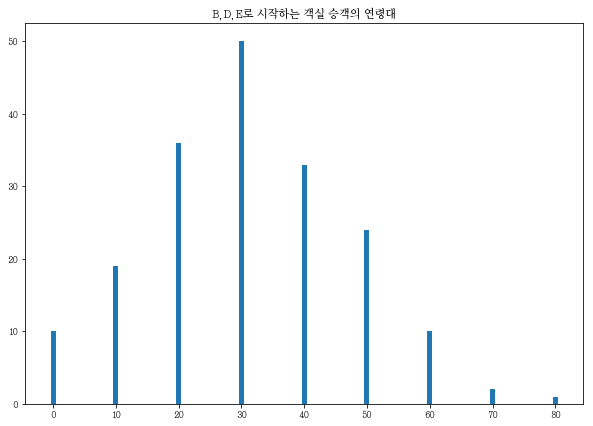

In [8]:
bdetmp = train.loc[train.Cabin.notnull()]
ageT = defaultdict(int)
for i in bdetmp.loc[bdetmp.Age.notnull()].Age:
    ageT[AgeClassify(i)] += 1

plt.figure(figsize=(10, 7))
plt.title('B,D,E로 시작하는 객실 승객의 연령대')
# plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
# plt.axis('equal')
# mpl.rcParams['font.size'] = 10.0
plt.bar(ageT.keys(), ageT.values())

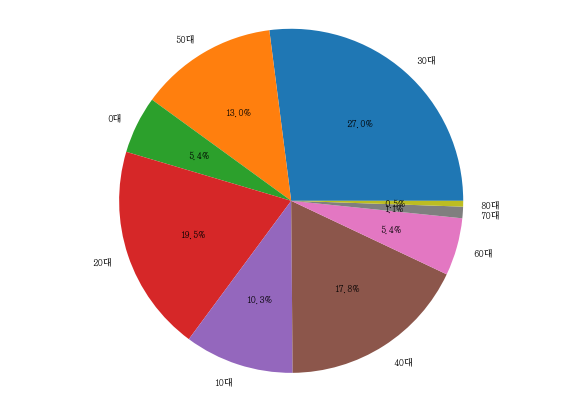

In [9]:
plt.figure(figsize=(10, 7))
plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 10.0

-----------------------------
30대(27%)가 가장 많고 20대(19.5%), 40대(17.8%), 50대(13%) 순으로 많다.

In [10]:
ttmp = defaultdict(int)
dtmp = defaultdict(int)
for a, t in zip(bdetmp.loc[bdetmp.Age.notnull()].Age,bdetmp.loc[bdetmp.Age.notnull()].Survived):
    ttmp[AgeClassify(a)] += t
    if t == 0:
        dtmp[AgeClassify(a)] += 1

total = defaultdict(int)
for k in range(0,90,10):
    try:
        total[k] = 100*ttmp[k]/(ttmp[k]+dtmp[k])
    except:
        continue
total

defaultdict(int,
            {0: 80.0,
             10: 78.94736842105263,
             20: 75.0,
             30: 76.0,
             40: 57.57575757575758,
             50: 54.166666666666664,
             60: 40.0,
             70: 0.0,
             80: 100.0})

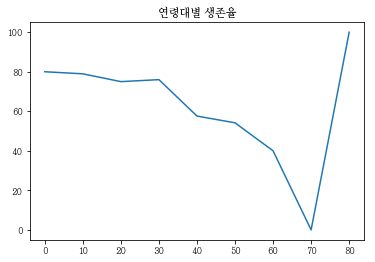

In [11]:
plt.title('연령대별 생존율')
plt.plot(total.keys(), total.values())

-----------------------------------
70대는 모두 사망(2명)했고, 80대는 모두 생존(1명)했다.


0~30대는 비교적 높고 비슷한 생존율을 유지하다가 40대부터 급격히 낮아지기 시작한다.

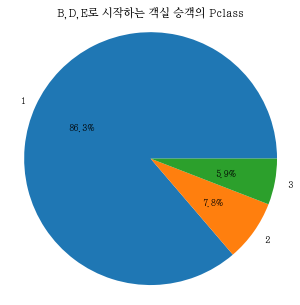

In [12]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Pclass')
plt.pie(bdetmp.Pclass.value_counts(),labels = [1,2,3],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

-------------------------------
86.3% 즉 대부분의 해당 객실 승객 사회적 지위가 높다.

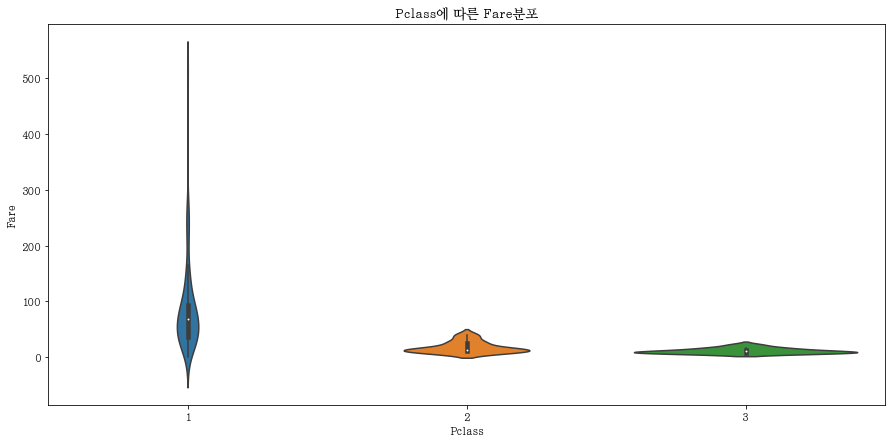

In [13]:
plt.figure(figsize = (15,7))
plt.title('Pclass에 따른 Fare분포')
sns.violinplot(x = bdetmp.Pclass, y = bdetmp.Fare )

-----------------------------------------
사회적 지위가 높을 수록 더 높은 요금을 내는 사람들이 많다. 



따라서 Pclass가 높을 수록 Fare도 높을 확률이 높다.

In [14]:
bdetmp.Fare.describe()#B,D,E 승객의 Fare 정보

count    204.000000
mean      76.141504
std       74.391749
min        0.000000
25%       29.453125
50%       55.220850
75%       89.328150
max      512.329200
Name: Fare, dtype: float64

In [15]:
train.Fare.describe()#전체승객의 Fare 정보

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

-----------------------------------------
평균값을 보아도, 사분위수를 보아도 B,D,E 승객이 비싼 요금을 낸다는 것을 알 수 있다.


그리고 가장 비싼 요금을 낸 사람도 B,D,E 승객중에 있다.

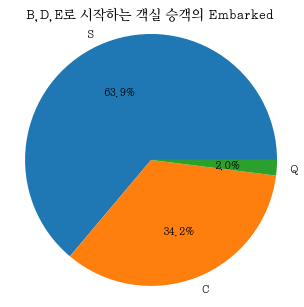

In [16]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Embarked')
plt.pie(bdetmp.Embarked.value_counts(),labels = ['S','C','Q'],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

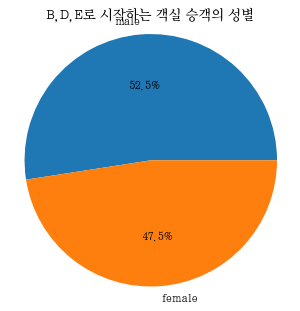

In [17]:

plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 성별')
plt.pie(bdetmp.Sex.value_counts(),labels = ['male','female'],autopct ='%1.1f%%')
plt.axis('equal')
plt.show()

-------------------------------
승선항구는 S가 64%로 가장 많고, Q는 2%로 거의 없는 편이다.


성별은 남성이 52%, 여성이 48%를 차지하고 있다.

------------------------------
## 결론
B,D,E로 시작하는 객실에 묵은 승객들의 <strong>생존확률이 70%가 넘는다</strong>는 사실을 알게 되었다.

그래서 해당 객실 승객들의 나이, 성별, 사회적 지위, 요금, 승선한 항구에 대해 알아보았다.

정리를 하자면,


나이는 20~40대가 가장 많고, 0~50대가 전체의 93%를 차지한다.



성별비율은 거의 1:1이다.



사회적 지위는 <strong>대부분(86%)이 1등급</strong>이다.



<strong>비싼 요금을 낸 승객들은 모두 사회적 지위가 높은 승객들이고, 이 승객들은 해당 객실에 포함</strong>되어 있다.



승선 항구는 S항구가 가장 많고(64%), Q항구는 거의 없다(2%)


여기서 가장 눈에 띄는 것은, 해당 객실 승객들이 대부분 <strong>사회적 지위가 높은 사람들</strong>이라는 것이다.


그리고 이 사회적 지위가 높은 사람들은 대부분 <strong>높은 요금</strong>을 지불했다.


그래서 해당 객실 승객들의 생존확률이 높은 것에 가장 큰 영향을 준 것은 <strong>Pclass와 Fare</strong>이고, B,D,E로 시작하는 객실은 비싸고 좋은 객실이었을 것이라 생각한다.


이렇게 B,D,E객실 승객에 대해 분석하고나니, 다른 객실 승객들에 대해서도 궁금해졌다.


### 결측치 처리
Cabin은 train뿐만 아니라 test데이터도 많은 양이 누락되어 잇다.

그래서 나는 이렇게 할 생각이다.

1. Cabin값이 있나? 
- Y: B,D,E 중 하나고 Pclass도 높다면 생존
- N: 2번으로
2. Pclass값이 있나?
- Y: Pclass가 

## Age

Text(0, 0.5, 'Count')

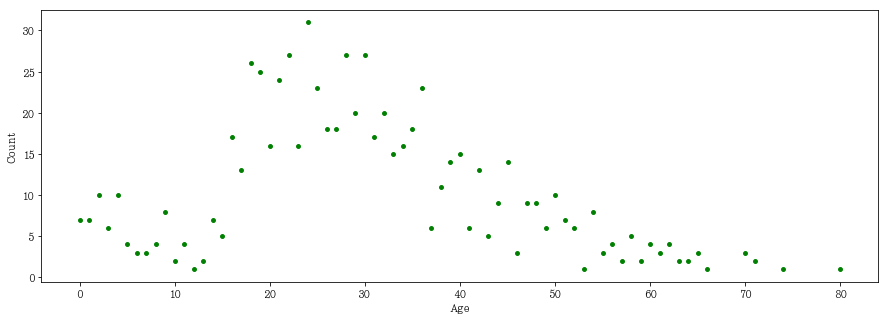

In [18]:
#전체 나이 분포
ageN = defaultdict(int)
for i in list(train.loc[train.Age.notnull()].Age):
    ageN[int(i)] += 1
plt.figure(figsize=(15, 5))
plt.scatter(ageN.keys(), ageN.values(),s = 15,c='g')
plt.xlabel('Age')
plt.ylabel('Count')

----------------------------------------------
10대 후반~ 30대 중후반의 승객이 많아보인다. 

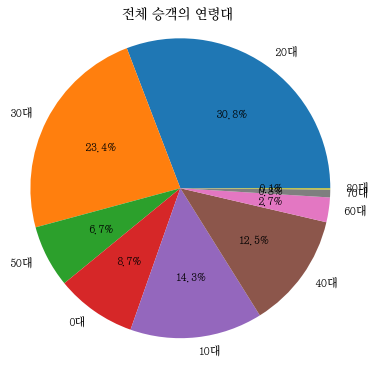

In [19]:
age2 = defaultdict(int)
for k,v in ageN.items():
    age2["{}대".format(AgeClassify(k))] += v
plt.figure(figsize=(6, 6))
plt.title('전체 승객의 연령대')
plt.pie(age2.values(), labels = age2.keys(),autopct ='%1.1f%%')
plt.axis('equal')
plt.show()

--------------------------------------------
20대가 압도적으로 많고, 그다음 30,10,40대 순으로 많다. 40대 이후로는 점차 줄어들고 있다.


0~40대가 전체의 약 90%를 차지한다.


다음은 연령별로 생존확률을 알아보려고 한다.

In [34]:
#key: 연령 ,value: 생존자 수
ageS = defaultdict(int)
#key: 연령, value: 전체 수
ageC = defaultdict(int)
for i,j in zip(train.loc[train.Age.notnull()].Age, train.loc[train.Age.notnull()].Survived):
    ageS[i] += j
    ageC[i] += 1
#각 연령별 생존 확률 계산
for k in ageC :
    ageS[k] = 100*ageS[k]/ageC[k]


Text(0.5, 0, '나이')

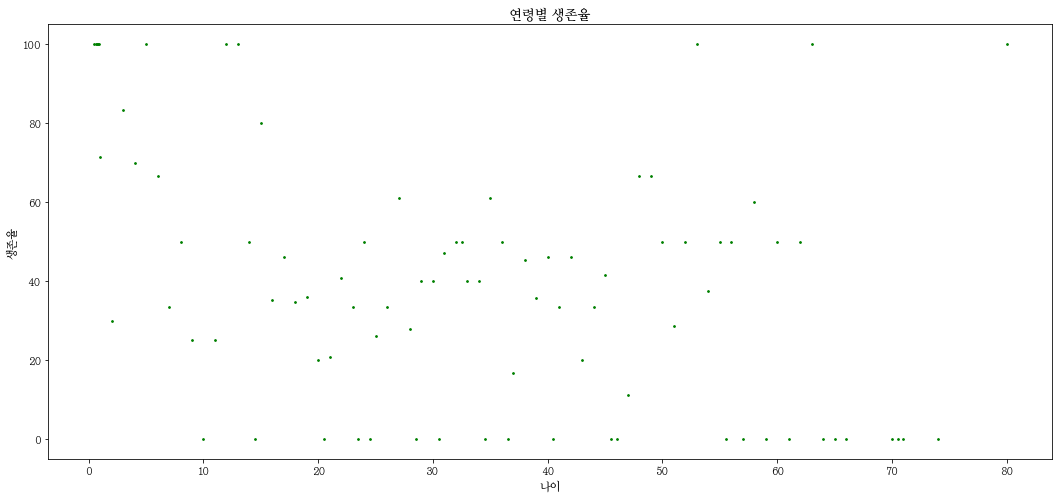

In [68]:
plt.figure(figsize = (18,8))
plt.title('연령별 생존율')
plt.scatter(x= ageS.keys(), y= ageS.values(),s = 3, c = 'g' )
plt.ylabel('생존율')
plt.xlabel('나이')

-----------------------------------
10세 미만인 승객 중에서는 생존율이 0%인 나이가 하나도 없고, 100%인 나이가 많다.

10대 후반부터 50대 초반까지는 생존율이 100%인 나이가 없고, 주로 0%이거나 20~60%사이의 생존율을 보이고있다.

60대 중반부터 70대 후반까지는 생존율이 모두 0%이다.

다음은 연령대별로 생존자, 사망자에 대해 분석해볼것이다.

In [112]:
#나이 분석을 위한 새로운 DataFrame
#생존자
SAge = pd.DataFrame(columns = [0, 10, 20, 30, 40, 50, 60,70,80],index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
#사망자
DAge = pd.DataFrame(columns = [0, 10, 20, 30, 40, 50, 60,70,80],index = ['count', 'mean', 'std','min', '25%', '50%', '75%', 'max'])

In [116]:
#생존자
for n in [10,20,30,40,50,60,70,80,90]:
    prev = n-10
    tmp = train.loc[prev<= train.Age ].loc[train.Age < n].loc[train.Survived == 1].Age.describe()
    SAge[prev] = tmp
SAge

,0,10,20,30,40,50,60,70,80
count,38.000000,41.000000,77.000000,73.000000,34.000000,20.000000,6.000000,0.0,1.0
mean,3.478158,16.634146,24.844156,33.883562,44.264706,53.200000,61.666667,NaN,80.0
std,2.489255,2.130212,2.636110,2.749395,3.240920,2.858045,1.366260,NaN,NaN
min,0.420000,11.000000,20.000000,30.000000,40.000000,50.000000,60.000000,NaN,80.0
25%,1.000000,15.000000,23.000000,32.000000,42.000000,50.750000,60.500000,NaN,80.0
50%,3.000000,17.000000,24.000000,34.000000,44.000000,52.500000,62.000000,NaN,80.0
75%,5.000000,18.000000,27.000000,36.000000,48.000000,55.250000,62.750000,NaN,80.0
max,9.000000,19.000000,29.000000,39.000000,49.000000,58.000000,63.000000,NaN,80.0


----------------------


In [115]:
#사망자
for n in [10,20,30,40,50,60,70,80,90]:
    prev = n-10
    tmp = train.loc[prev<= train.Age ].loc[train.Age < n].loc[train.Survived == 0].Age.describe()
    DAge[prev] = tmp
DAge

,0,10,20,30,40,50,60,70,80
count,24.000000,61.000000,143.000000,94.000000,55.000000,28.000000,13.000000,6.000000,0.0
mean,5.041667,16.877049,24.367133,33.930851,43.945455,53.625000,62.769231,71.083333,NaN
std,3.127427,2.360536,2.891191,2.961764,2.714284,3.008091,2.127355,1.497220,NaN
min,1.000000,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,NaN
25%,2.000000,16.000000,22.000000,31.000000,42.000000,51.000000,61.000000,70.125000,NaN
50%,4.000000,18.000000,24.000000,34.000000,44.000000,54.000000,62.000000,70.750000,NaN
75%,8.250000,19.000000,27.000000,36.000000,46.000000,56.000000,65.000000,71.000000,NaN
max,9.000000,19.000000,29.000000,39.000000,49.000000,59.000000,66.000000,74.000000,NaN


----------------------------------------------


## Pclass (사회적 지위)

In [35]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train.Sex.value_counts()

In [ ]:
train.PassengerId.describe()

In [ ]:
train.Parch.value_counts()

In [ ]:
train.Cabin.value_counts().head(10)

In [ ]:
train.Ticket.value_counts().head(10)

In [ ]:
train.Embarked.value_counts()

In [ ]:
#칭호 분리
m={}
for n in train.Name[:]:
    tmp = n.split(',')[1].split('.')[0].strip()
    m[tmp] = m.get(tmp, 0) +1 
print(m)

In [ ]:
train.SibSp.value_counts()

In [ ]:
train.Fare.describe()